# Flow Identification

In [ ]:
# For the purposes of this tutorial, we will turn off logging 
import logging
import os
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# Determines where configuration file is located
# # file contains directory info and model input settings
config_file = os.environ[
    "CANOPYHYDRO_CONFIG"
] = f"{os.getcwd()}/canopyhydro_config.toml"
log_config = os.environ["CANOPYHYDRO_LOG_CONFIG"] = f"{os.getcwd()}/logging_config.yml"

## Graph Models


CanoPyHydro estimates flow partitioning by enriching its cylinder data with a graph based model -  CylinderCollection.digraph. \
This graph representation simulates the tree's watershed and is used in tandem with a traversal algorithm to predict which percipitation partition each cylinder belongs to

In [ ]:
# How Graphs are initialized

import os

os.environ["CANOPYHYDRO_CONFIG"] = "./canopyhydro_config.toml"
from canopyhydro.CylinderCollection import CylinderCollection

# Initializing a CylinderCollection object
myCollection = CylinderCollection()

# Converting a specified file to a CylinderCollection object
myCollection.from_csv("5_SmallTree.csv")

# Requesting an plot of the tree projected onto the XY plane (birds-eye view)
myCollection.project_cylinders("XY")

# creating the digraph model
myCollection.initialize_digraph_from()

These graphs are instances of 'DiGraph' objects from the ['networkx' package](https://networkx.org/documentation/stable/reference/index.html). For more information regarding their capabilities, reffer to the afforementioned linked documentation.

For our purposes, you just need to know that the edges of these graphs correspond to the cylinders in a CylinderCollection. So, when the 'find_flow_components' function traverses a graph, it is akin to walking along the branches of the tree.

In [8]:
# See how cylinder 0 (the base of the tree) correlates
#  to edge 0 in our graph
print(myCollection.graph.edges(1,data=True))
print(myCollection.cylinders[1])

[(1, 0, {'cylinder': Cylinder( cyl_id=1.0, x=[-0.299115 -0.638138], y=[2.537844 2.995146], z=[-0.552    -0.354452], radius=0.531411, length=0.602566, branch_order=0.0, branch_id=0.0, volume=0.534583, parent_id=0.0, reverse_branch_order=67.0, segment_id=0.0})]
Cylinder( cyl_id=1.0, x=[-0.299115 -0.638138], y=[2.537844 2.995146], z=[-0.552    -0.354452], radius=0.531411, length=0.602566, branch_order=0.0, branch_id=0.0, volume=0.534583, parent_id=0.0, reverse_branch_order=67.0, segment_id=0.0


Each of the edges in the graph, also have a direction, depending on their angle in space. In particular, each edge is directed in the direction in which intercepted water is presumed to flow. 

During traversal, each edge may only be traversed in the direction it has been assigned. For example, every cylinder in the stem is oriented towards its base so, just as is the case with water, the only direction in which we can traverse from trunk edge to trunk edge is downward.

In [9]:
# Looking at the cylinders accessable from our stem cylinders (i.e. their neighbors)
print('The following cylinders are accessable from cylinder 5: ')
print([x for x in myCollection.graph.neighbors(5)])
print('The following cylinders are accessable from cylinder 4: ')
print([x for x in myCollection.graph.neighbors(4)])
print('The following cylinders are accessable from cylinder 3: ')
print([x for x in myCollection.graph.neighbors(3)])
print('The following cylinders are accessable from cylinder 2: ')
print([x for x in myCollection.graph.neighbors(2)])
print('The following cylinders are accessable from cylinder 1: ')
print([x for x in myCollection.graph.neighbors(1)])


The following cylinders are accessable from cylinder 5: 
[4]
The following cylinders are accessable from cylinder 4: 
[3]
The following cylinders are accessable from cylinder 3: 
[2]
The following cylinders are accessable from cylinder 2: 
[1]
The following cylinders are accessable from cylinder 1: 
[0]


## Finding Flows

This traversal (indeed much of anything at all to do with these graphs), is handled behind the scenes.

The code below shows how a user can call 'find_flow_components' to trigger the use of the collections graph and therefore identify the paths water takes - the flows - in the tree canopy

In [ ]:
# Finding the flows in the canopy

import os

os.environ["CANOPYHYDRO_CONFIG"] = "./canopyhydro_config.toml"
from canopyhydro.CylinderCollection import CylinderCollection

# Initializing a CylinderCollection object
myCollection = CylinderCollection()

# Converting a specified file to a CylinderCollection object
myCollection.from_csv("5_SmallTree.csv")

# Requesting an plot of the tree projected onto the XY plane (birds-eye view)
myCollection.project_cylinders("XY")

# creating the digraph model
myCollection.initialize_digraph_from()

# Traversing the graph, determining the fate of the water
# intercepted by each cylinder
myCollection.find_flow_components()

# For each of the possible destinations for said water,
#   summing the volume, area, etc of the contributing cylinders 
myCollection.calculate_flows()


To summarize the above:
 - We create a cylinder collection to hold the cylinders as well as ~1000 cylinders\
 that belong to that collection (Each with a surface area, length, etc.),
 - For each Cylinder, we calculate the properties of its 'XY' projection
 - We initialize a graph (stored in myCollection.Graph) for traversal
 - We travers the graph, and determine where water intercepted by cylinders ends up
 - For each contiguous group of cylinders *(Called a 'flow')*, we sum the total surface area, volumne etc. of each \
     cylinder

For more information on how the statistics calculated by 'calculate_flows' are used, see [statistics](statistics.ipynb)

## Figures


The usage of the 'watershed_boundary' function is coverd in the [Concave Hulls and Watersheds](watersheds.md) example doc, so we will not go too into depth on them here. 

Watershed boundaries can also be calculated for filtered sections of the tree in much of the same way. \
This is useful for creating figures and, perhaps more importantly, for generating statistics regarding the ground area covered by a tree's canopy

2024.10.14 18:32:37.020 |MainThread   | INFO    | geometry.py:563 -            draw_cyls() | model - Plotting cylinder collection

2024.10.14 18:32:37.140 |MainThread   | INFO    | CylinderCollection.py:403 -                 draw() | model - 517 cylinders matched criteria

overlay [<POLYGON ((-0.497 3.394, 1.788 4.044, 1.927 4.016, 2.113 3.284, 2.327 1.93, ...>]


2024.10.14 18:32:37.143 |MainThread   | INFO    | geometry.py:563 -            draw_cyls() | model - Plotting cylinder collection

2024.10.14 18:32:37.437 |MainThread   | ERROR   | geometry.py:591 -            draw_cyls() | model - Overlay must be a Polygon, a list of Polygons or coordinate list

2024.10.14 18:32:37.525 |MainThread   | INFO    | geometry.py:563 -            draw_cyls() | model - Plotting cylinder collection

2024.10.14 18:32:37.617 |MainThread   | INFO    | CylinderCollection.py:403 -                 draw() | model - 517 cylinders matched criteria

overlay [<POLYGON ((-0.639 3.355, -0.581 3.378, -0.497 3.394, -0.353 3.349, 1.567 2.8...>]


2024.10.14 18:32:37.621 |MainThread   | INFO    | geometry.py:563 -            draw_cyls() | model - Plotting cylinder collection

2024.10.14 18:32:38.002 |MainThread   | ERROR   | geometry.py:591 -            draw_cyls() | model - Overlay must be a Polygon, a list of Polygons or coordinate list

<Axes: >

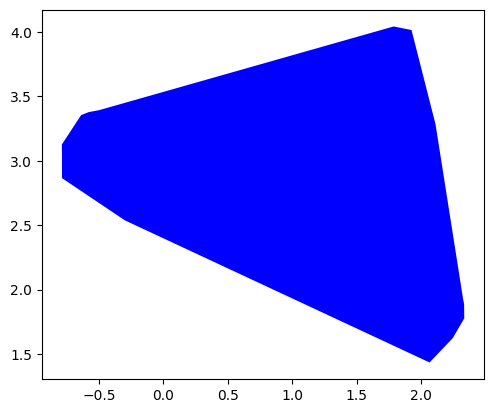

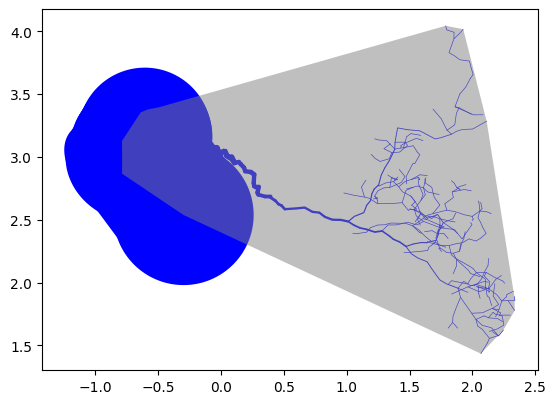

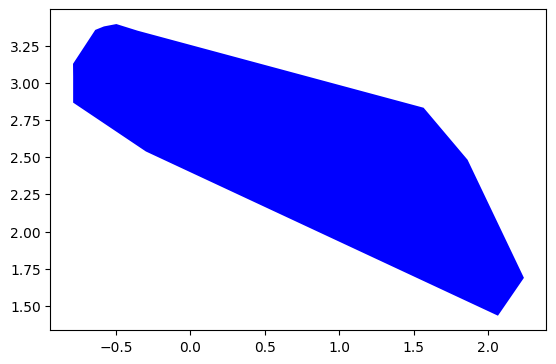

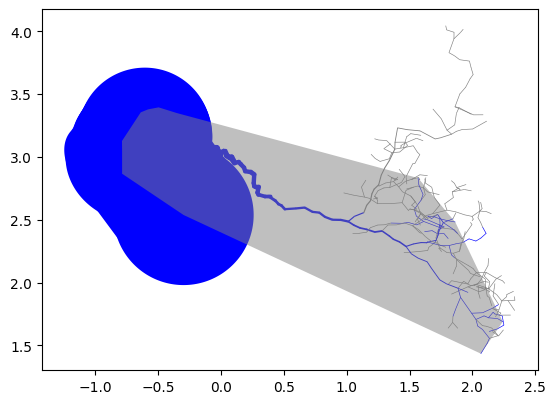

In [10]:
#Figures using 'is_stem'

#plotting the entire watershed boundary
whole_tree_hull,_ = myCollection.watershed_boundary(
    plane="XY",
    curvature_alpha=0.15,
    draw=True,
)

# plotting the whole tree boundary with the tree
#   with stemflow branches highlighted
myCollection.draw(
    "XY",
    include_alpha_shape=True
)

# plotting the boundary of the stemflow generating portion alone
stem_flow_hull,_ = myCollection.watershed_boundary(
    plane="XY",
    curvature_alpha=0.15,
    filter_lambda=lambda: is_stem ,
    draw=True,
)
# plotting the stemflow boundary with the tree
#   with stemflow branches highlighted
myCollection.draw(
    "XY",
    include_alpha_shape=True,
    highlight_lambda=lambda: is_stem
)



Once flows have been found for a cylinderCollection, the draw funtion can also access the locations of the drip points and overlay them onto a figure

2024.10.14 18:32:56.455 |MainThread   | INFO    | CylinderCollection.py:403 -                 draw() | model - 517 cylinders matched criteria

2024.10.14 18:32:56.461 |MainThread   | WARNING | CylinderCollection.py:433 -                 draw() | model - No drip point locations found, running set_drip_points

overlay [[[1.583993, 1.920238, 2.047486, 1.797333, 1.421225, 1.317245, 1.520497], [2.563848, 2.162247, 1.966398, 2.576308, 3.038762, 3.130179, 2.822484]]]


2024.10.14 18:32:56.468 |MainThread   | INFO    | geometry.py:563 -            draw_cyls() | model - Plotting cylinder collection

<Axes: >

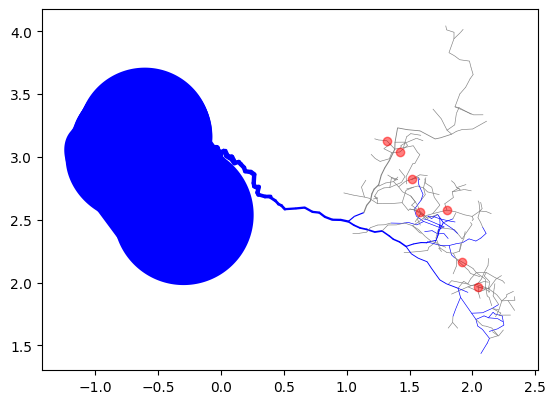

In [11]:
# Adding drip points to and XY view of myCollection
myCollection.draw(
    "XY",
    highlight_lambda=lambda: is_stem,
    include_drips=True,
)